# Autoregression Performance FFN vs RNN
> 일반적으로 FFN은 입력의 순차적 종속성을 modeling하는데 한계가 있어 autoregressive task에서 취약점을 가지고 있다. 반면 GRU 등의 RNN계열의 모델은 hidden state를 통해 step window 이전의 sequence에 대한 summary 정보를 활용할 수 있으며 GRU의 경우 추가로 gating mechanism을 가지고 있어 보다 long term 의존성에 강건한 특성을 갖는 것으로 알려져 있다. 이를 몇 가지 경우에 적용하여 FFN과 GRU가 보이는 특성의 경향을 살펴보고 예외적인 경우 그리고 실제 적용 시 유용할 수 있는 Implication을 정리할 예정


## 1. 단순한 주기성을 갖는 Sinusoidal Input에 대한 비교 실험
- Sinusoidal time series의 경우 매우 단순한 주기성을 갖고 있기 때문에 long term dependency를 다룰 수 없는 FFN로도 충분한 성능을 얻을 수 있을 것으로 예상된다. 이를 확인하기 위해 1 cycle의 sin timeseries 입력을 생성하여 학습 시키고 prediction의 step을 증가시키며 발생되는 error의 누적의 영향, step window의 fractional length (e.g. 1 / 100일 경우 전체 입력 sample이 1000개일 때 10)의 변화에 따라 어떻게 영향을 받는 지 등을 실험해 보고자 한다. 

- 유사한 규모의 FFN / RNN (GRU)
  - FNN 3개의 Hidden Layer를 갖는 FFN를 구성 ReLU를 Activation으로 사용하여 아래와 같이 구성
  - FNN Model (1.5K parameters)
  
```
(net): Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (3): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (4): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (5): Linear(in_features=20, out_features=1, bias=True)
)
```
- RNN Model (1.8K parameters)
```
(model): Sequential(
    (0): GRU(1, 10, num_layers=3, batch_first=True)
    (1): SelectItem()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
```



In [1]:
from model import FFNAutoregressor, GRUAutoregress, SinusoidalTimeSeries
import pytorch_lightning as pl
from torch.utils import data



ffn_model = FFNAutoregressor.load_from_checkpoint('./model/ffn/model.ckpt')
gru_model = GRUAutoregress.load_from_checkpoint('./model/gru/model.ckpt')

def total_param(model: pl.LightningModule):
    return sum(p.numel() for p in model.parameters())

print(f"FFN parameters : {total_param(ffn_model)}")
print(f"RNN parameters : {total_param(gru_model)}")


dataset = SinusoidalTimeSeries(0, n_samples=4000)
trainer = pl.Trainer(accelerator="gpu")
trainer.test(ffn_model, dataloaders=data.DataLoader(dataset=dataset, batch_size=50))
trainer.test(gru_model, dataloaders=data.DataLoader(dataset=dataset, batch_size=50))


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FFN parameters : 1690
RNN parameters : 1721


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/fritzprix/miniconda3/envs/directml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss         1.2969425370101817e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          1.194695300910098e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.194695300910098e-06}]

In [38]:
import utils
from model import SinusoidalTimeSeries
import train
import os
import torch

dataset = SinusoidalTimeSeries(0, n_samples=4000)
k_sweep = range(0, 30, 5)
device = torch.device('cuda')
batch_size = 50

reference = utils.predict_k_step_ahead(gru_model,dataset, batch_size=batch_size, device=device, ahead_step=0)
gru_preds = utils.sweep_kahead_pred(gru_model, dataset, k_sweep=k_sweep, device=device, batch_size=batch_size)
ffn_preds = utils.sweep_kahead_pred(ffn_model, dataset, k_sweep=k_sweep, device=device, batch_size=batch_size)



100%|██████████| 80/80 [00:00<00:00, 248.77it/s]


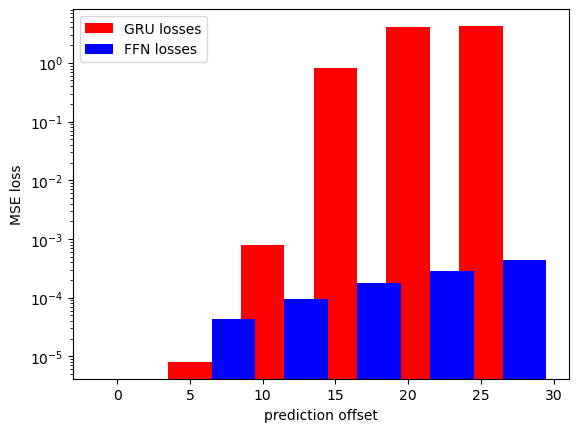

FFN Loss grow : 9.885105168406685
GRU Loss grow : 529094.8177411333


In [40]:
import utils
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np


gru_losses = [F.mse_loss(pred, reference).cpu().detach().item() for pred in gru_preds]
ffn_losses = [F.mse_loss(pred, reference).cpu().detach().item() for pred in ffn_preds]

x = np.array(k_sweep)
plt.bar(x, gru_losses, color='r', width=3, label='GRU losses')
plt.bar(x + 3, ffn_losses, color='b', width=3, label='FFN losses')
plt.xlabel('prediction offset')
plt.ylabel('MSE loss')
plt.legend()
plt.yscale('log')
plt.show()

print(f"FFN Loss grow : {ffn_losses[-1] / ffn_losses[1]}")
print(f"GRU Loss grow : {gru_losses[-1] / gru_losses[1]}")


## N-Step Prediction Sweep Test

> 예측 Step의 길이를 100 ~ 400까지 증가 시키면서 성능의 열화가 발생하는 정도는 RNN이 FFN보다 우위의 성능을 보였다. 다만 prediction step이 커질 수록 GRU가 loss 열화가 더 가속화 되는 측면이 있었다. (Why?)

- Step 1 prediction의 결과 거의 0에 수렴하는 mse loss값을 보임
- prediction step을 증가 시킬 때 오차가 얼마나 증가하는지 테스트